In [1]:
#@title Imports & Utils

!pip install -q jax-md

import imageio
import jax.numpy as jnp
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from jax_md import space
from jax_md.colab_tools import renderer
import jax
import numpy as np

sns.set_style(style='white')
background_color = [56 / 256] * 3


def make_all(box_size, num_1d, chain_length):
  displacement_fn, shift_fn = space.periodic(box_size)
  _1d_pos = jnp.linspace(0, box_size, num_1d + 1)[:num_1d]
  _1d_pos += 0.5 * box_size / num_1d
  colours = jnp.array([
      [125, 148, 181],
      # [200, 183, 166],
      [194, 149, 145],
      # [112, 63, 55],
      # [182, 193, 153],
  ]) / 255
  num_chains_lengthwise = num_1d // chain_length


  def chain_data(atom_index, start_x, start_y):
    chain_positions_x = start_x + jnp.linspace(
        0, box_size / num_chains_lengthwise, chain_length + 1
    )[:-1]
    chain_position_y = jnp.ones(chain_length) * start_y
    chain_positions = jnp.stack([chain_positions_x, chain_position_y]).T
    chain_bonds = jnp.stack([
        atom_index + jnp.arange(chain_length - 1),
        atom_index + jnp.arange(1, chain_length),
    ]).T
    num_chain_angle_bonds = chain_length - 2
    chain_angle_bonds = jnp.stack([
        atom_index + jnp.arange(0, chain_length - 2),
        atom_index + jnp.arange(1, chain_length - 1),
        atom_index + jnp.arange(2, chain_length - 0),
    ]).T
    species = [0, 0, 1]
    chain_angle_species = jnp.array(species, dtype=jnp.int32)
    atom_species = jnp.array([0] + species + [0], dtype=jnp.int32)
    chain_atom_colors = colours[atom_species]
    return (
        jnp.mod(chain_positions, box_size),
        chain_bonds,
        chain_angle_bonds,
        chain_angle_species,
        chain_atom_colors,
    )


  def make_row_of_chains(atom_index, start_y):
    start_y = start_y.repeat(num_chains_lengthwise)
    atom_indices = atom_index + jnp.arange(num_chains_lengthwise) * chain_length
    start_x = _1d_pos[::chain_length] + 2 * start_y
    out = jax.vmap(chain_data)(atom_indices, start_x, start_y)
    reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
    return jax.tree_map(reshape, out)

  row = jax.vmap(make_row_of_chains)(num_1d * jnp.arange(num_1d), _1d_pos)
  reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
  return displacement_fn, shift_fn, *jax.tree_map(reshape, row)

We want to model wet sand:

*   Grains are hard (no interpenetration).
*   Grains stick together a little bit.
*   Grains far away from one another don't notice each other.

Model the projectile by adding a term to the energy,

$$E = \sum_{i,j}\epsilon(r_{ij}) + \sum_i \epsilon_p(r_{ip})$$

where $r_{ip}$ is the distance between grain $i$ and the projectile.

Want the projectile to only repel the sand (no attraction).

Now, add the bond minimum angle as a parameter which is vmapped at the same level as the bond_angle_indices array.

In [2]:
strength = 1000.0
radius = jnp.array(2.0)
k_r = 10.0
k_theta = 10.0
r_eq = 1.1224594 * 1.000001
theta_eq = jnp.array([0.0, jnp.pi * 0.5])

def bond(r):
  return k_r * (r - r_eq) ** 2

def bond_angle_energy(theta, species):
  return k_theta * (theta - theta_eq[species]) ** 2

Text(0, 0.5, '$\\epsilon$')

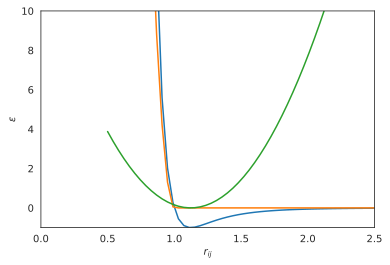

In [3]:
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))
plt.plot(rs, energy.soft_sphere(rs, epsilon=strength))
plt.plot(rs, bond(rs))

plt.ylim([-1, 10])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

Text(0, 0.5, 'recovered theta')

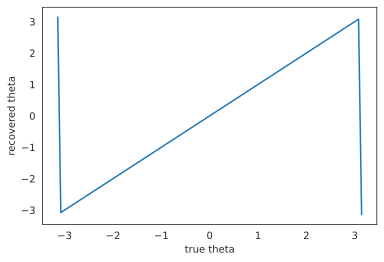

In [4]:
eps = 1e-4
def angle_metric(ra, rb, rc):
  rab = rb - ra
  rbc = rc - rb
  rab /= jnp.linalg.norm(rab)
  rbc /= jnp.linalg.norm(rbc)
  sin = rab[0] * rbc[1] - rbc[0] * rab[1]
  cos = rab[0] * rbc[0] + rab[1] * rbc[1]
  return jnp.arctan2(sin, cos)

t = jnp.linspace(-jnp.pi, jnp.pi, 100)
ra = jnp.array([0, 0])
rb = jnp.array([1, 0])
rc = jnp.array([1, 0])[None, :] + jnp.stack([jnp.cos(t), jnp.sin(t)]).T

plt.plot(t, [angle_metric(ra, rb, rc_) for rc_ in rc])
plt.xlabel('true theta')
plt.ylabel('recovered theta')

In [5]:
from jax_md.smap import _kwargs_to_bond_parameters, high_precision_sum
from typing import Callable, Optional, Dict, Union
from jax_md import util
from functools import partial

Array = util.Array

DisplacementOrMetricFn = space.DisplacementOrMetricFn

f32 = util.f32


# LR: edited jax_md.smap.bond, this is intended to work on an array with all
# atoms with two bonds
def bond_angles(fn: Callable[..., Array],
         displacement_or_metric: DisplacementOrMetricFn,
         static_bonds: Optional[Array]=None,
         static_bond_types: Optional[Array]=None,
         ignore_unused_parameters: bool=False,
         **kwargs) -> Callable[..., Array]:
  """Promotes a function that acts on a single pair to one on a set of bonds.

  TODO(schsam): It seems like bonds might potentially have poor memory access.
  Should think about this a bit and potentially optimize.

  Args:
    fn: A function that takes an ndarray of pairwise distances or displacements
      of shape `[n, m]` or `[n, m, d_in]` respectively as well as kwargs
      specifying parameters for the function. `fn` returns an ndarray of
      evaluations of shape `[n, m, d_out]`.
    metric: A function that takes two ndarray of positions of shape
      `[spatial_dimension]` and `[spatial_dimension]` respectively and returns
      an ndarray of distances or displacements of shape `[]` or `[d_in]`
      respectively. The metric can optionally take a floating point time as a
      third argument.
    static_bonds: An ndarray of integer pairs wth shape `[b, 2]` where each
      pair specifies a bond. `static_bonds` are baked into the returned compute
      function statically and cannot be changed after the fact.
    static_bond_types: An ndarray of integers of shape `[b]` specifying the
      type of each bond. Only specify bond types if you want to specify bond
      parameters by type. One can also specify constant or per-bond parameters
      (see below).
    ignore_unused_parameters: A boolean that denotes whether dynamically
      specified keyword arguments passed to the mapped function get ignored
      if they were not first specified as keyword arguments when calling
      `smap.bond(...)`.
    kwargs: Arguments providing parameters to the mapped function. In cases
      where no bond type information is provided these should be either

        1. a scalar
        2. an ndarray of shape `[b]`.

      If bond type information is provided then the parameters should be
      specified as either

        1. a scalar
        2. an ndarray of shape `[max_bond_type]`.
        3. a ParameterTree containing a PyTree of parameters and a mapping. See
           ParameterTree for details.
  Returns:
    A function `fn_mapped`. Note that `fn_mapped` can take arguments bonds and
    `bond_types` which will be bonds that are specified dynamically. This will
    incur a recompilation when the number of bonds changes. Improving this
    state of affairs I will leave as a TODO until someone actually uses this
    feature and runs into speed issues.
  """

  # Each call to vmap adds a single batch dimension. Here, we would like to
  # promote the metric function from one that computes the distance /
  # displacement between two vectors to one that acts on two lists of vectors.
  # Thus, we apply a single application of vmap.

  merge_dicts = partial(util.merge_dicts,
                        ignore_unused_parameters=ignore_unused_parameters)

  def compute_fn(R, bonds, bond_types, static_kwargs, dynamic_kwargs):
    Ra = R[bonds[:, 0]]
    Rb = R[bonds[:, 1]]
    Rc = R[bonds[:, 2]]
    _kwargs = merge_dicts(static_kwargs, dynamic_kwargs)
    _kwargs = _kwargs_to_bond_parameters(bond_types, _kwargs)
    # NOTE(schsam): This pattern is needed due to JAX issue #912.
    d = jax.vmap(partial(displacement_or_metric, **dynamic_kwargs), 0, 0)
    dr = d(Ra, Rb, Rc)
    return high_precision_sum(fn(dr, **_kwargs))

  def mapped_fn(R: Array,
                bonds: Optional[Array]=None,
                bond_types: Optional[Array]=None,
                **dynamic_kwargs) -> Array:
    accum = f32(0)

    if bonds is not None:
      accum = accum + compute_fn(R, bonds, bond_types, kwargs, dynamic_kwargs)

    if static_bonds is not None:
      accum = accum + compute_fn(
          R, static_bonds, static_bond_types, kwargs, dynamic_kwargs)

    return accum
  return mapped_fn

In [6]:
box_size = 100.0
displacement_fn, shift_fn, positions, bonds, bonds_for_angle, bond_species, colors = make_all(
    box_size=box_size, num_1d=50, chain_length=5
)

renderer.render(box_size, renderer.Disk(positions, color=colors))

In [7]:
from jax_md import smap

def bond_energy(pos):
  bond_type = None
  return smap.bond(
    bond,
    space.canonicalize_displacement_or_metric(displacement_fn),
    bonds,
    bond_type,
  )(pos)

def angle_energy(pos):
  static_bond_types = None
  return bond_angles(
    partial(bond_angle_energy, species=bond_species),
    angle_metric,
    bonds_for_angle,
    static_bond_types,
  )(pos)

def softsphere(positions):
  return energy.soft_sphere_pair(
      displacement_fn, sigma=radius + 1.0, epsilon=100.0 # strength
  )(positions)

def total_energy(positions):
  return (
      softsphere(positions) + bond_energy(positions) + angle_energy(positions)
  )

In [8]:
from jax_md import minimize
from jax import jit

def run_minimization(energy_fn, R_init, shift, num_steps=50):
  dt_start = 0.001
  dt_max   = 0.004
  init, apply = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=dt_start, dt_max=dt_max
  )
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = jax.lax.scan(scan_fn,state,np.arange(num_steps))

  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position)))

positions_relaxed, max_force_component = run_minimization(total_energy, positions, shift_fn)

/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/reductions.py:206: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [9]:
total_energy(positions)

DeviceArray(62255.76, dtype=float32)

In [10]:
from jax import grad
g = grad(angle_energy)(positions)
int(jnp.isnan(g).sum()), np.prod(g.shape)

(0, 5000)

In [11]:
renderer.render(box_size, renderer.Disk(positions, color=colors))

In [12]:
from jax_md import simulate
from jax_md import dataclasses
from jax import lax


@dataclasses.dataclass
class Chains:
  chains: simulate.NVTLangevinState

simulation_steps = 10000
write_every = 50
write_steps = simulation_steps // write_every

init_fn, step_fn = simulate.nvt_langevin(total_energy, shift_fn, dt=5e-3, kT=0.0)


def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory

  traj = Chains(
      traj.chains.at[i].set(state.chains.position),
  )

  def total_step_fn(_, state):
    return Chains(
        step_fn(state.chains),
    )

  state = lax.fori_loop(0, write_every, total_step_fn, state)

  return state, traj

In [13]:
projectile = jnp.array([1.0, box_size / 3.0])

radius = jnp.array(2.0)
strength = 1000.0
velocity = jnp.array([1e-2, 0.0])

In [ ]:
n = positions.shape[0]

key = jax.random.PRNGKey(seed=0)

state = Chains(init_fn(key, positions),)
trajectory = Chains(jnp.zeros((write_steps, n, 2)),)

state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (state, trajectory))
renderer.render(
    box_size,
    {
        'chains': renderer.Disk(trajectory.chains, color=colors),
    }
)